In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [66]:
# Data Loader
csf_data = pd.read_csv("merged_csf_cross_sectional_call_rate_pau_data_0205.xls", low_memory=False)
plasma_data = pd.read_csv("merged_plasma_cross_sectional_call_rate_data_0130.xls", low_memory=False)

In [3]:
plasma_data['Status_at_draw_mapping'].value_counts()

Status_at_draw_mapping
CO     1282
AD      865
PD      687
DLB     122
FTD      44
Name: count, dtype: int64

In [4]:
# plasma_data

In [5]:
csf_significant_rows = pd.read_csv("csf_significant_rows_0205.csv")
plasma_significant_rows = pd.read_csv("plasma_significant_rows_0203.csv")

### Data Loader

In [169]:
data = plasma_data.copy()
print(data.shape)

(4750, 6648)


In [170]:
x_columns = [col for col in plasma_data.columns if col.startswith('X')]
len(x_columns)

6607

In [171]:
protein_list = list(plasma_significant_rows['Analytes'])
print(len(protein_list))
# protein_list

3607


In [172]:
data['Status_at_draw'].value_counts()

Status_at_draw
CO                                 1841
AD                                 1118
PD                                  693
HC                                  360
OT                                  284
DLB                                 122
PDD                                  92
MCI                                  66
MSA                                  27
MCI-PD                               26
PGRN_Unaffected_Non_carrier          19
FTD                                  15
AD_DLB                               10
ADAD_Unaffected_Non_carrier          10
PGRN_Non_carrier                      9
C9ORF72_Affected_carrier              7
PGRN_Presymptomatic_carrier           6
Unknown                               6
ADAD_Presymptomatic_carrier           6
PGRN_Unaffected_carrier_Unknown       6
MAPT_Presymptomatic_carrier           5
PGRN_Affected_carrier                 5
ADAD_Affected_carrier                 3
LBD                                   2
CA                       

In [173]:
data['Project_y'].value_counts()

Project_y
MAP         3110
PD          1012
Stanford     628
Name: count, dtype: int64

In [174]:
filtered_data = data.copy()
print(filtered_data.shape)

(4750, 6648)


### LightGBM Model Performance

In [175]:
import joblib
# csf_lgbm_model = joblib.load("csf_model_output/csf_lgbm_model_400_0411.pkl")
csf_lgbm_model = joblib.load("plasma_model_output/plasma_lgbm_model_700_0411.pkl")

In [176]:
# with open("csf_model_output/csf_selected_features_400_0411.txt", "r") as f:
with open("plasma_model_output/plasma_selected_features_700_0411.txt", "r") as f:
    csf_selected_features = [line.strip() for line in f.readlines()]

existing_features = [feature for feature in csf_selected_features if feature in filtered_data.columns]
selected_data = filtered_data[existing_features]

print(f"Total selected features: {len(csf_selected_features)}")
print(f"Existing features in dataset: {len(existing_features)}")

Total selected features: 700
Existing features in dataset: 700


In [177]:
print(filtered_data.shape)
print(selected_data.shape)

(4750, 6648)
(4750, 700)


In [178]:
X_new = selected_data.iloc[:, :]

y_pred = csf_lgbm_model.predict(X_new)
y_pred_proba = csf_lgbm_model.predict_proba(X_new)

print("Predicted Labels:", y_pred)
print("Predicted Probabilities:\n", y_pred_proba)

Predicted Labels: [1 1 1 ... 1 1 1]
Predicted Probabilities:
 [[4.29910817e-01 5.65269131e-01 1.84867105e-05 2.14616885e-05
  4.78010368e-03]
 [1.31652818e-05 9.99983065e-01 1.58628837e-06 3.75585769e-07
  1.80747806e-06]
 [5.52104959e-06 9.99986445e-01 1.44451712e-06 1.56829648e-07
  6.43303078e-06]
 ...
 [3.38069023e-04 9.64522628e-01 4.46077304e-05 3.75357124e-05
  3.50571599e-02]
 [9.71100613e-04 9.96228165e-01 1.04955181e-03 1.30199860e-05
  1.73816300e-03]
 [1.69389747e-05 9.98211652e-01 2.54987629e-06 2.25291282e-05
  1.74633004e-03]]


In [179]:
status_labels = filtered_data['Status_at_draw'].str.upper()
y_pred_proba_df = pd.DataFrame(y_pred_proba, index=status_labels.index, columns=[f"{label} Probability" for label in ['AD', 'CO', 'DLB', 'FTD', 'PD']])
predicted_classes = y_pred_proba_df.idxmax(axis=1).str.replace(' Probability', '')

results_df = pd.DataFrame({
    "UniquePhenoID": filtered_data['UniquePhenoID'],
    "DrawDate": filtered_data['DrawDate'],
    "Project_y": filtered_data['Project_y'],
    "Status_at_draw": filtered_data['Status_at_draw'].str.upper(),
    "Status_at_draw_mapping": filtered_data['Status_at_draw_mapping'],
    "Final_Status": filtered_data['Final_Status'],
    "Age_at_draw": filtered_data['Age_at_draw'],
    "Age_onset": filtered_data['Age_onset'],
    "Age_at_last": filtered_data['Age_at_last'],
    "Sex": filtered_data['Sex'],
    "Final_Status_Data": filtered_data['Last_CDR_testdate'],
    "AT Status": filtered_data['AT_class'],
    "ATN_DrawDate": filtered_data['ATN_drawdate'],
    "Amyloid PET Imaging": filtered_data['final_decision'],
    "PET_DrawDate": filtered_data['PET_Date'],
    "ptau217": filtered_data['T1_pTau217'],
    "ptau217_DrawDate": filtered_data["T1T2_DrawDate"],
    "CDR_score_closest": filtered_data['CDR_score_closest'],
    "Last_CDR_score": filtered_data['Last_CDR_score'],
    # "Predicted Class": label_encoder.inverse_transform(y_pred)
    "Predicted Class": predicted_classes
})

results_df = pd.concat([results_df, y_pred_proba_df], axis=1)
# results_df

# results_df.to_csv("csf_status_predictions_4677_400_0522.csv", index=False)
# results_df.to_csv("plasma_status_predictions_4750_700_0523.csv", index=False)

In [180]:
results_df['Status_at_draw'].value_counts()

Status_at_draw
CO                                 1841
AD                                 1118
PD                                  693
HC                                  360
OT                                  284
DLB                                 122
PDD                                  92
MCI                                  66
MSA                                  27
MCI-PD                               26
PGRN_UNAFFECTED_NON_CARRIER          19
FTD                                  15
AD_DLB                               10
ADAD_UNAFFECTED_NON_CARRIER          10
PGRN_NON_CARRIER                      9
C9ORF72_AFFECTED_CARRIER              7
PGRN_PRESYMPTOMATIC_CARRIER           6
UNKNOWN                               6
ADAD_PRESYMPTOMATIC_CARRIER           6
PGRN_UNAFFECTED_CARRIER_UNKNOWN       6
MAPT_PRESYMPTOMATIC_CARRIER           5
PGRN_AFFECTED_CARRIER                 5
ADAD_AFFECTED_CARRIER                 3
ADAD_AFFECTED_NON_CARRIER             2
LBD                      

### Evaluation Matrix

In [74]:
# ===========================================================
# ★  1)  Prepare labels and probability matrix
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from matplotlib.lines import Line2D

# Assumes `results_df` contains:
#   - 'Status_at_draw': ground-truth diagnosis label
#   - 'Predicted Class': predicted diagnosis label
#   - Probability columns for each class: 'AD Probability', etc.

# Define fixed class order and corresponding probability column names
class_order = ['AD', 'CO', 'DLB', 'FTD', 'PD']
proba_cols  = [f"{c} Probability" for c in class_order]

# Filter to include only target classes and ensure uppercase consistency
results_df = results_df[results_df['Status_at_draw'].isin(class_order)].copy()
results_df['Status_at_draw'] = results_df['Status_at_draw'].str.upper()

# Encode class labels using fixed class order
label_encoder = LabelEncoder().fit(class_order)
y_true_lbl = results_df['Status_at_draw']
y_pred_lbl = results_df['Predicted Class']
y_test     = label_encoder.transform(y_true_lbl)
y_pred     = label_encoder.transform(y_pred_lbl)
y_test_proba = results_df[proba_cols].values

class_labels = label_encoder.classes_
n_classes    = len(class_labels)
n_samples    = len(y_true_lbl)

# ===========================================================
# ★  2)  Confusion Matrix & Derived Metrics (TP, FN, FP, TN)
# ===========================================================
cm = confusion_matrix(y_true_lbl, y_pred_lbl, labels=class_labels)

# Compute per-class metrics: sensitivity, specificity, accuracy
N = cm.sum()
rows = []
for idx, cls in enumerate(class_labels):
    TP = cm[idx, idx]
    FN = cm[idx, :].sum() - TP
    FP = cm[:, idx].sum() - TP
    TN = N - TP - FN - FP
    sens = TP / (TP + FN) if TP + FN else np.nan
    spec = TN / (TN + FP) if TN + FP else np.nan
    acc  = (TP + TN) / N
    rows.append(dict(Class=cls, TP=TP, FN=FN, FP=FP, TN=TN,
                     Sensitivity=round(sens,3),
                     Specificity=round(spec,3),
                     Accuracy=round(acc,3)))
conf_df = pd.DataFrame(rows)
print("\n=== Confusion-matrix-derived counts & metrics ===")
print(conf_df)


=== Confusion-matrix-derived counts & metrics ===
  Class    TP   FN   FP    TN  Sensitivity  Specificity  Accuracy
0    AD   911  207  269  2402        0.815        0.899     0.874
1    CO  1492  349  225  1723        0.810        0.884     0.849
2   DLB    87   35    9  3658        0.713        0.998     0.988
3   FTD    12    3    1  3773        0.800        1.000     0.999
4    PD   611   82  172  2924        0.882        0.944     0.933


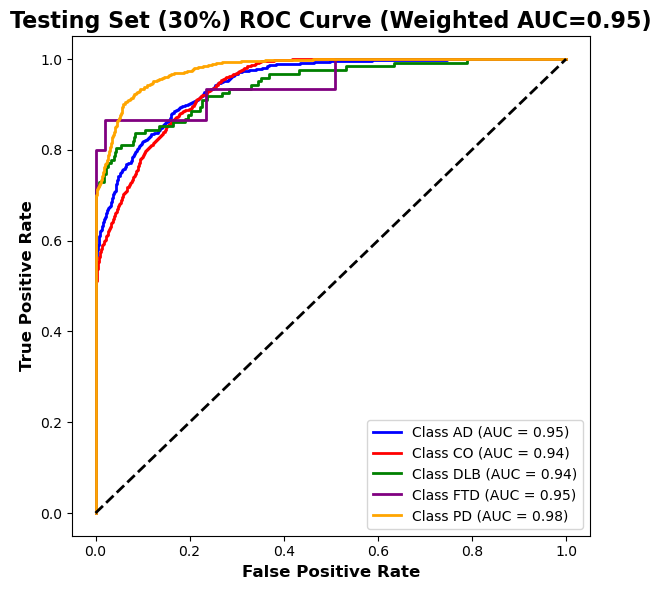

In [73]:
# ===========================================================
# ★  3)  ROC Curves and AUC Calculation
# ===========================================================
y_test_bin = label_binarize(y_true_lbl, classes=class_labels)
sample_cnt = y_test_bin.sum(axis=0)

# Calculate ROC curve and AUC per class
fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(class_labels):
    if sample_cnt[i] == 0:  # Skip classes without positive samples
        roc_auc[i] = np.nan
        fpr[i] = tpr[i] = np.array([0,1])
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute weighted AUC across all classes
valid      = sample_cnt > 0
weights    = sample_cnt[valid] / sample_cnt[valid].sum()
auc_weight = np.average([roc_auc[i] for i in range(n_classes) if valid[i]],
                        weights=weights)

# Plot ROC curves
plt.figure(figsize=(6,6))
colors = cycle(['blue','red','green','purple','orange'])
for i, color in zip(range(n_classes), colors):
    if np.isnan(roc_auc[i]):
        continue
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0,1],[0,1],'k--',lw=2)
plt.xlabel('False Positive Rate', size=12, weight='bold')
plt.ylabel('True Positive Rate',  size=12, weight='bold')
plt.title(f'Testing Set (30%) ROC Curve (Weighted AUC={auc_weight:.2f})',
          size=16, weight='bold')
plt.legend(loc='lower right')
plt.grid(False)
plt.tight_layout()
plt.show()

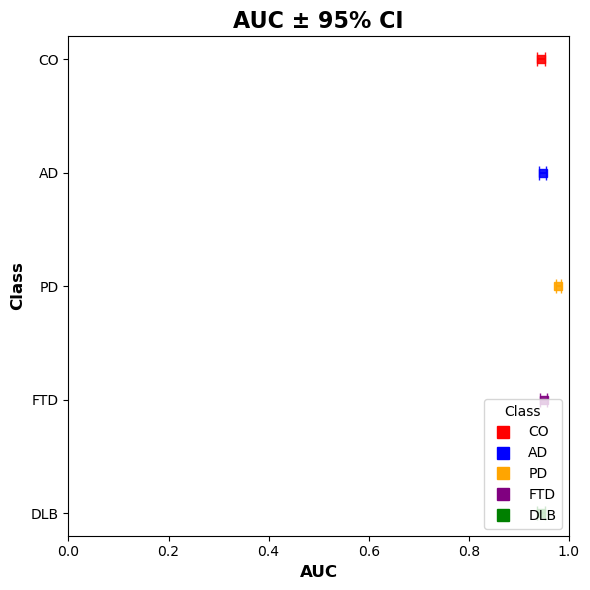

In [71]:
# ===========================================================
# ★  4)  AUC ± 95% Confidence Interval (Wald Method)
# ===========================================================
auc_rows = []
for i, cls in enumerate(class_labels):
    if sample_cnt[i] == 0:
        continue
    auc_val = roc_auc[i]
    se_auc  = np.sqrt((auc_val*(1-auc_val))/n_samples)
    ci_low, ci_up = auc_val-1.96*se_auc, auc_val+1.96*se_auc
    auc_rows.append([cls, auc_val, ci_low, ci_up])

auc_df = pd.DataFrame(auc_rows, columns=['Class','AUC','CI_low','CI_up'])

# Plot AUC with error bars
order     = ['CO','AD','PD','FTD','DLB']
color_map = {'AD':'blue','CO':'red','DLB':'green','FTD':'purple','PD':'orange'}
auc_df['Class'] = pd.Categorical(auc_df['Class'], categories=order, ordered=True)
auc_df = auc_df.sort_values('Class', ascending=False)

plt.figure(figsize=(6,6))
for _, r in auc_df.iterrows():
    plt.errorbar(r['AUC'], r['Class'],
                 xerr=[[r['AUC']-r['CI_low']],
                       [r['CI_up']-r['AUC']]],  # CI as x-error
                 fmt='s', color=color_map[r['Class']], capsize=5, alpha=0.9)
plt.xlabel('AUC', size=12, weight='bold')
plt.ylabel('Class', size=12, weight='bold')
plt.title('AUC ± 95% CI', size=16, weight='bold')
plt.xlim(0,1); plt.grid(False)
cust = [Line2D([0],[0], color=color_map[c], marker='s', linestyle='',
               markersize=8) for c in order]
plt.legend(cust, order, title='Class', loc='lower right')
plt.tight_layout(); plt.show()

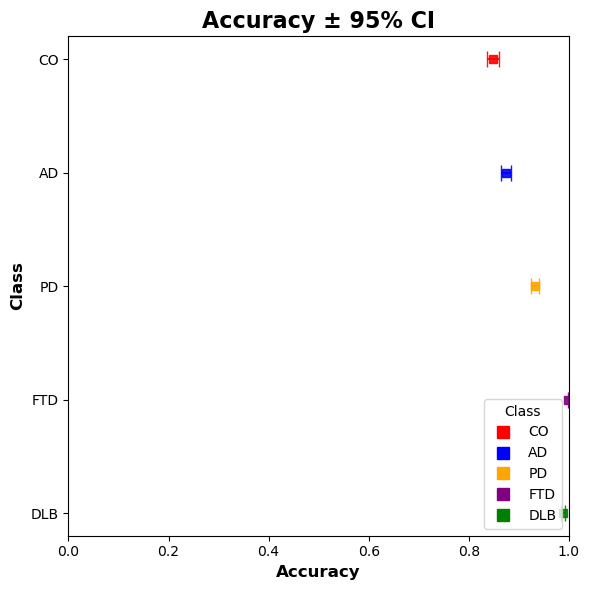

In [70]:
# ===========================================================
# ★  5)  Accuracy ± 95% Confidence Interval (Wald Method)
# ===========================================================
acc_rows = []
for _, r in conf_df.iterrows():
    TP, FN, FP, TN = r['TP'], r['FN'], r['FP'], r['TN']
    acc = (TP+TN) / (TP+TN+FP+FN)
    se  = np.sqrt(acc*(1-acc)/N)
    acc_rows.append([r['Class'], acc, acc-1.96*se, acc+1.96*se])

acc_df = pd.DataFrame(acc_rows, columns=['Class','Accuracy','CI_low','CI_up'])
acc_df['Class'] = pd.Categorical(acc_df['Class'], categories=order, ordered=True)
acc_df = acc_df.sort_values('Class', ascending=False)

# Plot Accuracy with CI
plt.figure(figsize=(6,6))
for _, r in acc_df.iterrows():
    plt.errorbar(r['Accuracy'], r['Class'],
                 xerr=[[r['Accuracy']-r['CI_low']],
                       [r['CI_up']-r['Accuracy']]],
                 fmt='s', color=color_map[r['Class']], capsize=6, alpha=0.9)
plt.xlabel('Accuracy', size=12, weight='bold')
plt.ylabel('Class',   size=12, weight='bold')
plt.title('Accuracy ± 95% CI', size=16, weight='bold')
plt.xlim(0,1); plt.grid(False)
plt.legend(cust, order, title='Class', loc='lower right')
plt.tight_layout(); plt.show()

In [69]:
# ===========================================================
# ★  6)  Print per-class summary
# ===========================================================
print("\n=== Per-class summary ===")
for cls in class_labels:
    row = conf_df[conf_df['Class']==cls].iloc[0]
    print(f"Class {cls}:")
    print(f"  AUC:         {roc_auc[class_order.index(cls)]:.3f}")
    print(f"  Sensitivity: {row['Sensitivity']:.3f}")
    print(f"  Specificity: {row['Specificity']:.3f}")
    print(f"  Accuracy:    {row['Accuracy']:.3f}\n")


=== Per-class summary ===
Class AD:
  AUC:         0.948
  Sensitivity: 0.815
  Specificity: 0.899
  Accuracy:    0.874

Class CO:
  AUC:         0.944
  Sensitivity: 0.810
  Specificity: 0.884
  Accuracy:    0.849

Class DLB:
  AUC:         0.944
  Sensitivity: 0.713
  Specificity: 0.998
  Accuracy:    0.988

Class FTD:
  AUC:         0.949
  Sensitivity: 0.800
  Specificity: 1.000
  Accuracy:    0.999

Class PD:
  AUC:         0.979
  Sensitivity: 0.882
  Specificity: 0.944
  Accuracy:    0.933



### Final Status Check

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

crosstab_df = pd.crosstab(results_df['Final_Status'], results_df['Predicted Class'])

print(crosstab_df)

# plt.figure(figsize=(10, 6))
# sns.heatmap(crosstab_df, annot=True, fmt='d', cmap='YlGnBu')
# plt.title("Status_at_draw vs. Predicted Class")
# plt.xlabel("Predicted Class")
# plt.ylabel("True Class (Status_at_draw)")
# plt.tight_layout()
# plt.show()

Predicted Class                   AD   CO  DLB  FTD   PD
Final_Status                                            
AD                               535   88    3   11   20
AD vs FTD                          0    0    0    4    1
AD vs LBD                          1    0    0    0    0
ADAD_Affected_Non_carrier          0    6    0    0    3
ADAD_Affected_carrier             73   10    0    1   29
ADAD_Presymptomatic_carrier       18  102    0    2   62
ADAD_Unaffected_Non_carrier        2  121    0    1   56
C9ORF72_Presymptomatic_carrier     0    0    0    1    0
CO                                82  551    0    4  226
Clinic_AD                        362  137    4    3   35
Clinic_CO                         27  103    0    2    8
Clinic_OT                          4    8    0    0    1
DLB                                3    1   19    1    9
DLB_PD                             1    0    0    0    0
Dementia                           0    0    0    0    2
Dystonia                       

### Single Category Radar Plot

In [62]:
def calculate_mean_and_ci(data, confidence=0.95):
    mean = np.mean(data, axis=0)
    se = np.std(data, axis=0) / np.sqrt(len(data))
    ci = se * 1.96  # 95% CI
    return mean, mean - ci, mean + ci

In [63]:
def plot_radar_chart(mean, lower_ci, upper_ci, title):
    # Extract class labels by removing ' Probability' from column names
    labels = [col.replace(' Probability', '') for col in results_df.columns if 'Probability' in col]
    num_vars = len(labels)

    # Compute angles for each axis on the radar chart
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]  # Close the loop

    # Initialize the radar chart figure
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Repeat the first value to close the radar shape
    mean_values   = list(mean) + [mean[0]]
    lower_ci_vals = list(lower_ci) + [lower_ci[0]]
    upper_ci_vals = list(upper_ci) + [upper_ci[0]]

    # Plot the mean and confidence interval lines
    ax.fill(angles, mean_values, color='#1f77b4', alpha=0.25)
    ax.plot(angles, mean_values, color='#1f77b4', linewidth=2, linestyle='solid', label='Mean')
    ax.plot(angles, lower_ci_vals, color='#1f77b4', linewidth=2, linestyle='dashed', label='95% CI')
    ax.plot(angles, upper_ci_vals, color='#1f77b4', linewidth=2, linestyle='dashed')

    # Configure the axis and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=28, fontweight='bold')
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=18, fontweight='bold')

    # Highlight only the direction with the highest mean value
    idx_max = int(np.argmax(mean))

    # Annotate only the max mean value (no CI shown)
    ax.text(angles[idx_max], mean_values[idx_max] + 0.05,
            f'{mean_values[idx_max]:.2f}',
            ha='center', va='center',
            fontsize=28, fontweight='bold', color='black')

    # (Commented out: CI annotations)
    # ax.text(angles[idx_max], lower_ci_vals[idx_max] - 0.05, f'{lower_ci_vals[idx_max]:.2f}', ...)
    # ax.text(angles[idx_max], upper_ci_vals[idx_max] + 0.03, f'{upper_ci_vals[idx_max]:.2f}', ...)

    # Show the plot
    # plt.title(title, fontsize=20, fontweight='bold', y=1.08)  # optional
    plt.tight_layout()
    plt.show()

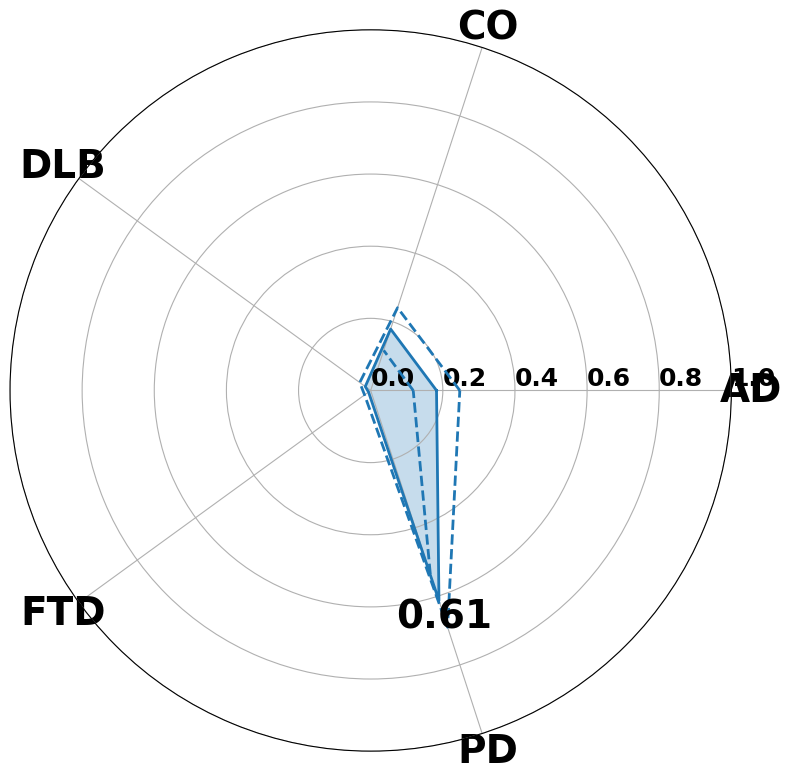

In [64]:
# Loop over target classes to create radar plots for each
# for true_class in ['ADAD_AFFECTED_CARRIER']:  # You can add more classes here
for true_class in ['PDD']:  # You can add more classes here
    # Filter the dataset to get only samples of the selected class
    subset = results_df[results_df['Status_at_draw'] == true_class]

    # Extract probability columns as NumPy array
    probabilities = subset[[col for col in results_df.columns if 'Probability' in col]].values

    # Compute mean and 95% CI
    mean, lower_ci, upper_ci = calculate_mean_and_ci(probabilities)

    # Generate radar chart
    plot_radar_chart(mean, lower_ci, upper_ci, f'Radar Plot for {true_class}')

### Neuralpathological Trail and Cognitive Tests

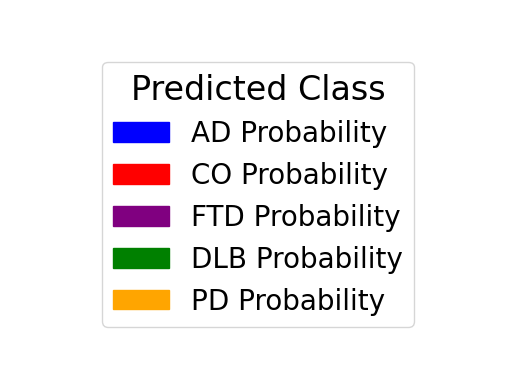

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colors = ['blue', 'red', 'purple', 'green', 'orange']
labels = ['AD Probability', 'CO Probability', 'FTD Probability', 'DLB Probability', 'PD Probability']

handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

fig, ax = plt.subplots()
ax.axis('off')
legend = ax.legend(handles=handles, title='Predicted Class', loc='center', fontsize=20, title_fontsize=24)

plt.show()

(2267, 6)


C:\Users\x.ying1\AppData\Local\Temp\ipykernel_31032\2533238774.py:21: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


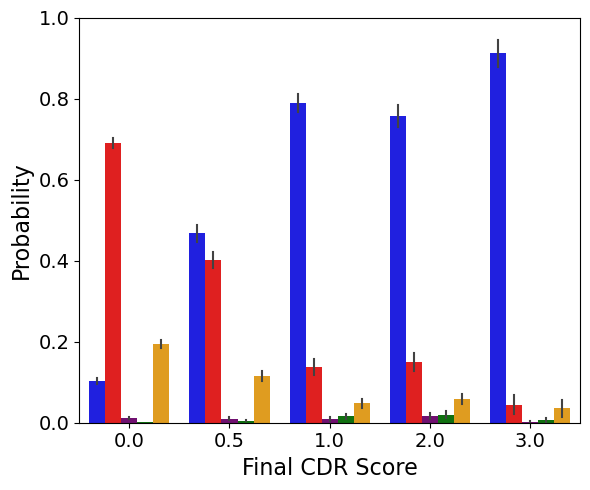

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_vars = ['AD Probability', 'CO Probability', 'FTD Probability', 'DLB Probability', 'PD Probability']
colors = ['blue', 'red', 'purple', 'green', 'orange']
palette = dict(zip(y_vars, colors))

categorical_vars = [
    'Last_CDR_score'
]

for var in categorical_vars:
    plot_data = results_df[[var] + y_vars].dropna()
    print(plot_data.shape)
    plot_data_melted = plot_data.melt(id_vars=var, value_vars=y_vars, 
                                      var_name='Prediction', value_name='Probability')

    plt.figure(figsize=(6, 5))
    sns.barplot(
        data=plot_data_melted,
        x=var,
        y='Probability',
        hue='Prediction',
        estimator=np.mean,
        errorbar=('se'),
        palette=palette,
        errwidth=1.5
    )

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1)
    # plt.title(f'{cat_var}', fontsize=18, fontweight='bold')
    plt.xlabel("Final CDR Score", size=16)
    plt.ylabel('Probability', size=16)
    # plt.legend(title='Predicted Class', loc='upper right', fontsize=12, title_fontsize=13)
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()

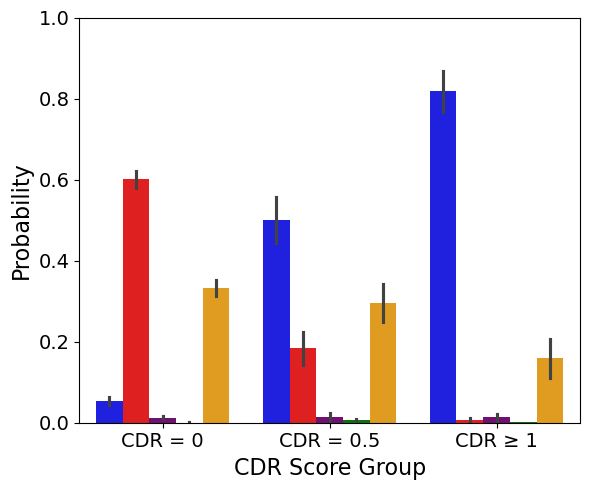

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

subset = results_df[results_df['Status_at_draw'].isin([
    'ADAD_AFFECTED_CARRIER', 'ADAD_PRESYMPTOMATIC_CARRIER', 'ADAD_UNAFFECTED_NON_CARRIER'
])]

required_cols = ['CDR_score_closest', 'AD Probability', 'CO Probability', 'PD Probability', 'FTD Probability', 'DLB Probability']
subset = subset.dropna(subset=required_cols)

def bin_cdr(score):
    if score == 0:
        return 'CDR = 0'
    elif score == 0.5:
        return 'CDR = 0.5'
    else:
        return 'CDR ≥ 1'

subset['CDR_group'] = subset['CDR_score_closest'].apply(bin_cdr)

melted = subset.melt(
    id_vars='CDR_group',
    value_vars=['AD Probability', 'CO Probability', 'FTD Probability', 'DLB Probability', 'PD Probability'],
    var_name='Status',
    value_name='Probability'
)

melted['CDR_group'] = pd.Categorical(
    melted['CDR_group'],
    categories=['CDR = 0', 'CDR = 0.5', 'CDR ≥ 1'],
    ordered=True
)

color_map = {
    'AD Probability': 'blue',
    'CO Probability': 'red',
    'FTD Probability': 'purple',
    'DLB Probability': 'green',
    'PD Probability': 'orange'
}

plt.figure(figsize=(6, 5))
sns.barplot(
    data=melted,
    x='CDR_group',
    y='Probability',
    hue='Status',
    palette=color_map,
    estimator=np.mean,
    errorbar='se'
)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 1)
# plt.title("ADAD Affected & Unaffected: CDR Score", fontsize=18, fontweight='bold')
plt.xlabel("CDR Score Group", size=16)
plt.ylabel("Probability", size=16)
# plt.legend(title='Predicted Class', loc='upper right', fontsize=12, title_fontsize=13)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()


### Biomarker Validation

In [181]:
results_df['PET_Diff'] = (pd.to_datetime(results_df['PET_DrawDate'], format='mixed', errors='coerce') -
                          pd.to_datetime(results_df['DrawDate'], format='mixed', errors='coerce')).dt.days
results_df['ptau217_Diff'] = (pd.to_datetime(results_df['ptau217_DrawDate'], format='mixed', errors='coerce') -
                              pd.to_datetime(results_df['DrawDate'], format='mixed', errors='coerce')).dt.days
results_df['ATN_Diff'] = (pd.to_datetime(results_df['ATN_DrawDate'], format='mixed', errors='coerce') -
                          pd.to_datetime(results_df['DrawDate'], format='mixed', errors='coerce')).dt.days

# results_df = results_df[
#     (results_df['ATN_Diff'].abs() <= 183) | results_df['ATN_Diff'].isna()
# ]
# results_df = results_df[
#     (results_df['PET_Diff'].abs() <= 183) | results_df['PET_Diff'].isna()
# ]
# results_df = results_df[
#     (results_df['ptau217_Diff'].abs() <= 183) | results_df['ptau217_Diff'].isna()
# ]

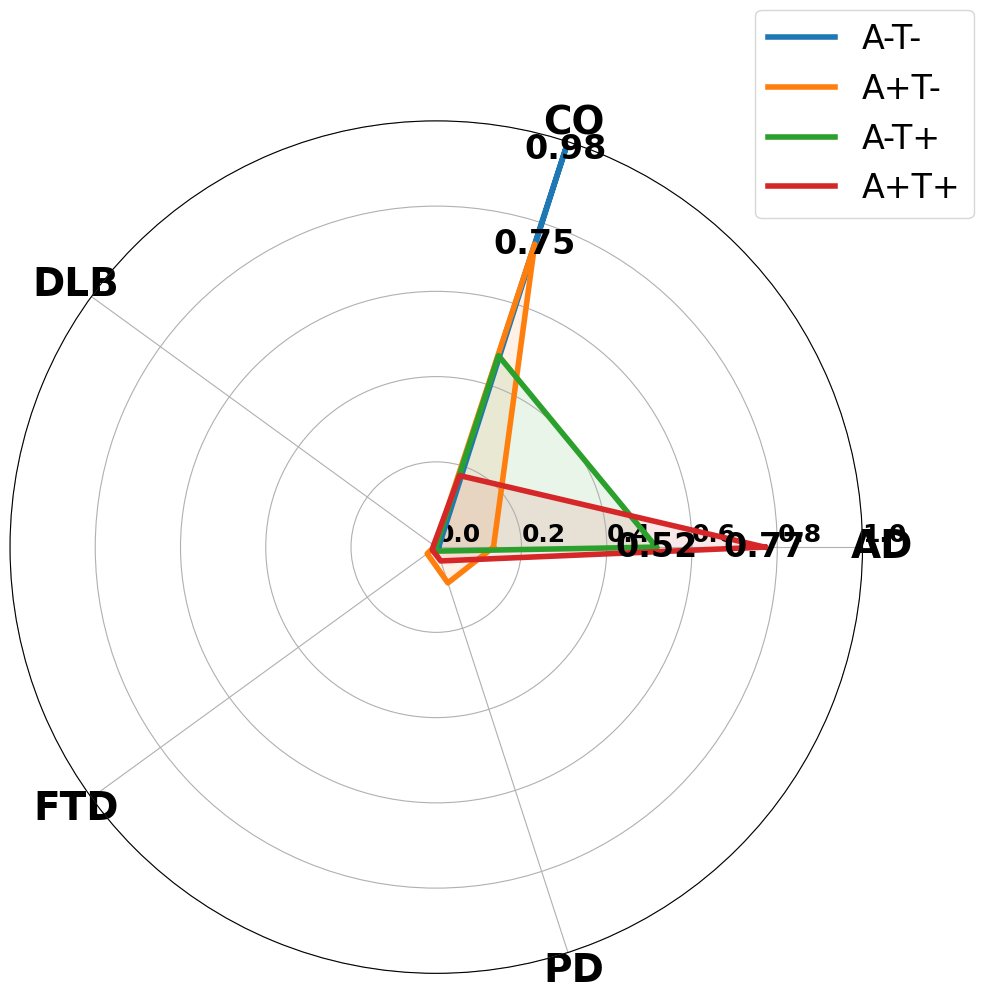

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Define probability columns and corresponding class labels
prob_cols = ['AD Probability', 'CO Probability', 'DLB Probability', 'FTD Probability', 'PD Probability']
labels = [col.replace(' Probability', '') for col in prob_cols]
num_vars = len(labels)

# Compute angles for radar axes (one per class)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Close the radar circle

# Define target AT groups to plot (can be replaced with any subgroup of interest)
target_classes = ['A-T-', 'A+T-', 'A-T+', 'A+T+']

# Color mapping for each AT status group
colors = {
    'A-T-': '#1f77b4',  # Blue
    'A+T-': '#ff7f0e',  # Orange
    'A-T+': '#2ca02c',  # Green
    'A+T+': '#d62728'   # Red
}

# Initialize radar plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Loop over each AT status group
for status in target_classes:
    group = results_df[
        (results_df['AT Status'] == status) &
        (results_df['Status_at_draw'] == 'CO') &  # Filter to OT clinical group
        (results_df['ATN_Diff'].abs() <= 183)     # Restrict to samples with recent ATN measures
    ]

    values = group[prob_cols].values

    if len(values) == 0:
        continue  # Skip group if no data

    # Compute mean probabilities for each class
    mean = np.mean(values, axis=0)
    mean_values = list(mean) + [mean[0]]  # Close the radar loop

    # Draw radar line and fill area
    ax.plot(angles, mean_values, label=status, linewidth=4, linestyle='solid', color=colors[status])
    ax.fill(angles, mean_values, alpha=0.1, color=colors[status])

    # Annotate the maximum predicted class (peak of the radar)
    main_idx = np.argmax(mean)
    ax.text(
        angles[main_idx],
        mean[main_idx],
        f'{mean[main_idx]:.2f}',
        ha='center',
        va='center',
        fontsize=24,
        fontweight='bold',
        color='black'
    )


# Set axis labels and style
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=28, fontweight='bold')

ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=18, fontweight='bold')
ax.set_rlabel_position(0)
ax.set_ylim(0, 1)

# Add plot title and legend
# plt.title("CSF Clinical OT Radar Plot by AT Status", fontsize=26, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15), fontsize=24, title_fontsize=28)

plt.tight_layout()
plt.show()
plt.close()


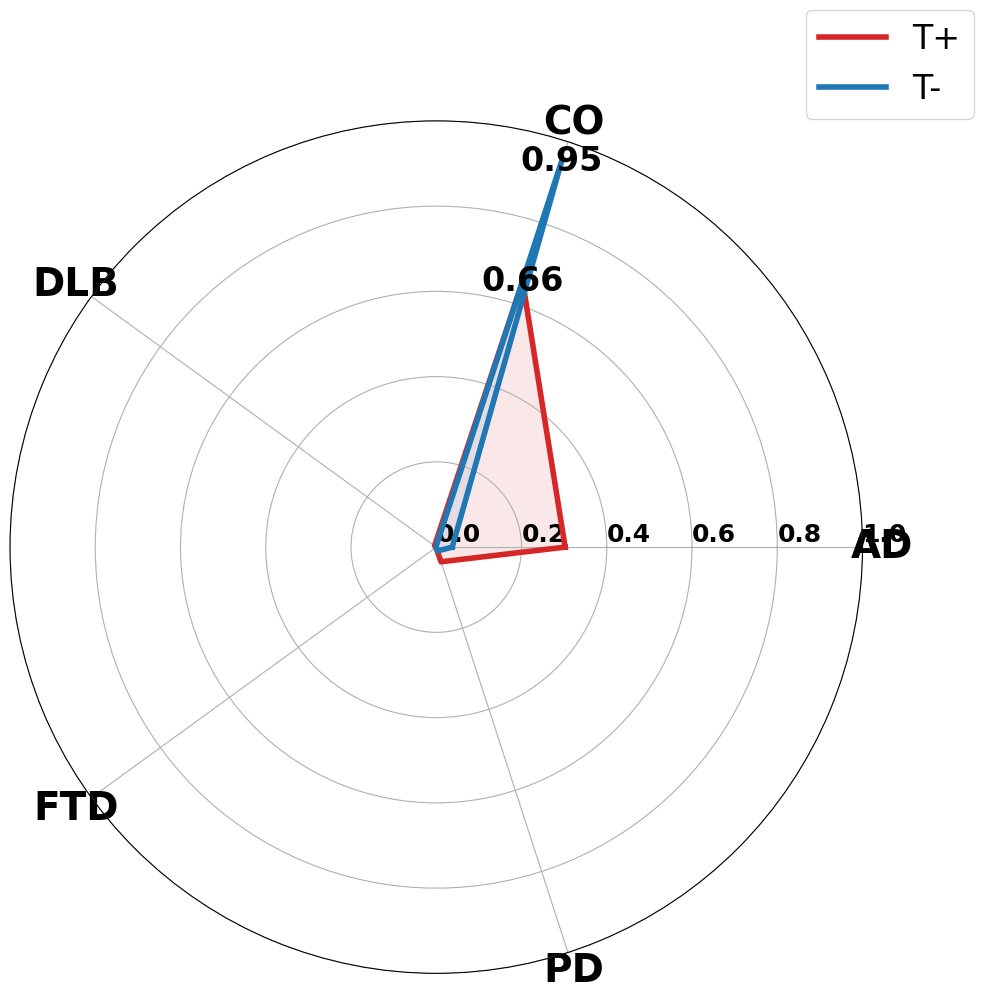

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Define class probability columns and corresponding labels
prob_cols = ['AD Probability', 'CO Probability', 'DLB Probability', 'FTD Probability', 'PD Probability']
labels = [col.replace(' Probability', '') for col in prob_cols]
num_vars = len(labels)

# Compute angles for radar chart axes (evenly spaced around a circle)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Close the radar loop

# Group by binary pTau217 status (T+ vs T-)
target_classes = ['T+', 'T-']

# Color mapping for each pTau217 group
colors = {
    'T+': '#d62728',  # Red
    'T-': '#1f77b4'   # Blue
}

# Initialize radar plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Loop over T+ and T- groups
for status in target_classes:
    group = results_df[
        (results_df['ptau217'] == status) &                  # Group by T+/T-
        (results_df['Status_at_draw'] == 'CO') &             # Only clinical OT samples
        (results_df['ptau217_Diff'].abs() <= 183)            # Measurement within ±183 days
    ]
    values = group[prob_cols].values

    if len(values) == 0:
        continue  # Skip empty groups

    # Calculate mean and 95% confidence interval
    mean = np.mean(values, axis=0)
    se = np.std(values, axis=0) / np.sqrt(len(values))
    ci = 1.96 * se  # (not plotted here, but computed if needed)
    mean_values = list(mean) + [mean[0]]  # Close the radar shape

    # Plot radar line and fill area
    ax.plot(angles, mean_values, label=status, linewidth=4, linestyle='solid', color=colors[status])
    ax.fill(angles, mean_values, alpha=0.1, color=colors[status])

    # Annotate maximum predicted class probability
    main_idx = np.argmax(mean)
    ax.text(
        angles[main_idx],
        mean[main_idx],
        f'{mean[main_idx]:.2f}',
        ha='center',
        va='center',
        fontsize=24,
        fontweight='bold',
        color='black'
    )

# Set radar chart labels and formatting
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=28, fontweight='bold')
ax.set_rlabel_position(0)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=18, fontweight='bold')
ax.set_ylim(0, 1)

# Set chart title
# plt.title("Plasma OT Radar Plot by pTau217 (T+ vs T-)", fontsize=26, fontweight='bold', pad=20)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15), fontsize=24, title_fontsize=28)

# Display and close plot
plt.tight_layout()
plt.show()
plt.close()

#### CSF AT Status

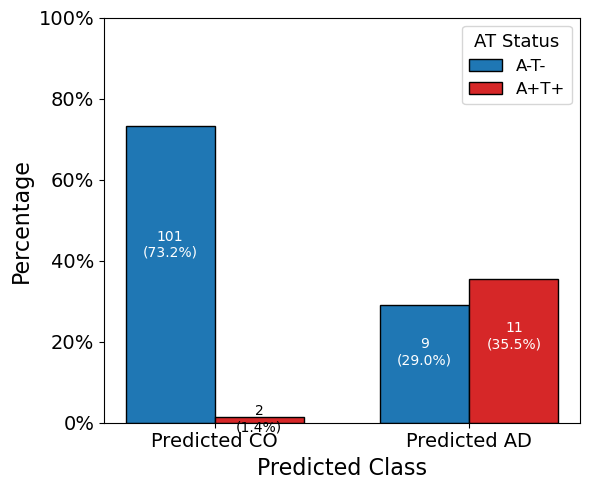

In [167]:
# Set color mapping for each AT status group
colors = {
    'A-T-': '#1f77b4',  # Blue
    'A+T+': '#d62728'   # Red
}

# Define all four canonical AT statuses for ratio calculation
all_four = ['A-T-', 'A+T-', 'A-T+', 'A+T+']

# Filter to include only samples with 'OT' clinical status (i.e., Other)
subset_df = results_df[results_df['Status_at_draw'] == 'OT']

# Initialize a list to store plot data
plot_data = []

# Loop over predicted classes: CO (control) and AD (Alzheimer's Disease)
for pred_class in ['CO', 'AD']:
    group = subset_df[subset_df['Predicted Class'] == pred_class]

    # ✅ Optional: restrict to samples with ATN_Diff within ±183 days
    # This ensures AT classification is temporally aligned
    group = group[(group['ATN_Diff'].abs() <= 183)]

    # Count AT status occurrences
    full_counts = group['AT Status'].value_counts()

    # Total count includes only the defined 4 AT statuses
    total = full_counts.loc[full_counts.index.intersection(all_four)].sum() or 1  # Avoid divide-by-zero

    # Compute proportion for each AT status (only A-T- and A+T+ are shown)
    for at_status in colors:
        count = full_counts.get(at_status, 0)
        prop = count / total
        plot_data.append({
            'Predicted Class': pred_class,
            'AT Status': at_status,
            'Count': count,
            'Proportion': prop
        })

# Convert plot data to DataFrame
plot_df = pd.DataFrame(plot_data)

# ========== Plotting ==========
plt.figure(figsize=(6, 5))

# Set base x-positions and bar width
x = [0, 1]  # 0 for 'CO', 1 for 'AD'
bar_width = 0.35
xticks = [r + bar_width / 2 for r in x]  # Center tick labels between bars

# Plot grouped bars for each AT status
for i, at_status in enumerate(colors.keys()):
    props = plot_df[plot_df['AT Status'] == at_status]['Proportion'].values
    counts = plot_df[plot_df['AT Status'] == at_status]['Count'].values
    xpos = [r + i * bar_width for r in x]  # Adjust x positions per group

    # Draw bars
    bars = plt.bar(
        xpos,
        props,
        width=bar_width,
        label=at_status,
        color=colors[at_status],
        edgecolor='black'
    )

    # Annotate bar with count and percentage
    for j in range(len(xpos)):
        plt.text(
            xpos[j],
            props[j] * 0.6,
            f"{counts[j]}\n({props[j]:.1%})",
            ha='center',
            va='center',
            fontsize=10,
            color='white' if props[j] > 0.1 else 'black'
        )

# Set axis labels and title
plt.xticks(xticks, ['Predicted CO', 'Predicted AD'], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Predicted Class', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
# plt.title('CSF AT Status in Clinical OT\nby Predicted Class', fontsize=18, weight='bold')
plt.ylim(0, 1)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add legend
plt.legend(title='AT Status', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()


#### ptau217

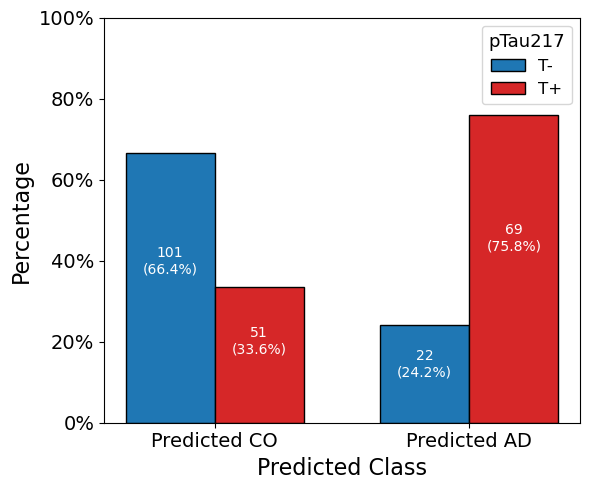

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define color mapping for binary pTau217 classification
colors = {
    'T-': '#1f77b4',  # Blue for negative
    'T+': '#d62728'   # Red for positive
}

# Step 1: Filter to include only clinically defined CO samples
# and restrict to samples where plasma pTau217 was measured within ±183 days
subset_df = results_df[
    (results_df['Status_at_draw'] == 'OT') &
    (results_df['ptau217_Diff'].abs() <= 183)
]

# Step 2: Aggregate count and proportion of pTau217 statuses per predicted class
plot_data = []
for pred_class in ['CO', 'AD']:
    group = subset_df[subset_df['Predicted Class'] == pred_class]
    counts = group['ptau217'].value_counts()
    
    # Only include T+/T- and avoid division by zero
    total = counts.loc[counts.index.intersection(colors.keys())].sum() or 1

    for status in colors:
        count = counts.get(status, 0)
        prop = count / total
        plot_data.append({
            'Predicted Class': pred_class,
            'ptau217': status,
            'Count': count,
            'Proportion': prop
        })

# Convert to DataFrame for plotting
plot_df = pd.DataFrame(plot_data)

# Step 3: Plot side-by-side bar chart for each status within each predicted class
plt.figure(figsize=(6, 5))
bar_width = 0.35
x = [0, 1]  # x positions for 'Predicted CO' and 'Predicted AD'
xticks = [r + bar_width / 2 for r in x]  # Center xtick labels between grouped bars

# Draw bars for each pTau217 category
for i, status in enumerate(colors.keys()):
    counts = plot_df[plot_df['ptau217'] == status]['Count'].values
    props = plot_df[plot_df['ptau217'] == status]['Proportion'].values
    xpos = [r + i * bar_width for r in x]

    bars = plt.bar(
        xpos,
        props,
        width=bar_width,
        color=colors[status],
        edgecolor='black',
        label=status
    )

    # Annotate bar with counts and percentages
    for j in range(len(xpos)):
        plt.text(
            xpos[j],
            props[j] * 0.6,
            f"{counts[j]}\n({props[j]:.1%})",
            ha='center',
            va='center',
            fontsize=10,
            color='white' if props[j] > 0.1 else 'black'
        )

# Step 4: Format plot aesthetics
plt.xticks(xticks, ['Predicted CO', 'Predicted AD'], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Predicted Class', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
# plt.title('Plasma pTau217 in Clinical CO\nby Predicted Class',
          # fontsize=18, weight='bold')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add legend
plt.legend(title='pTau217', loc='upper right', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()


#### Amyloid PET Imaging

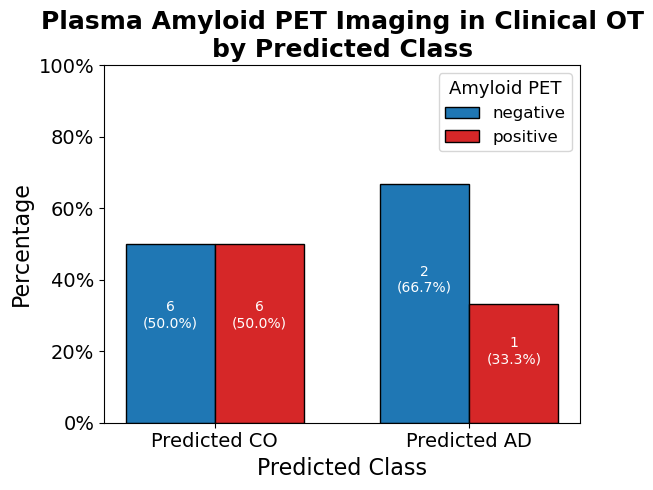

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define color mapping for amyloid PET imaging status
colors = {
    'negative': '#1f77b4',  # Blue
    'positive': '#d62728'   # Red
}

# Filter to include only samples with clinical label 'OT' (Other)
subset_df = results_df[results_df['Status_at_draw'] == 'OT']

# ✅ Apply PET imaging date filter (±183 days from clinical draw, or missing)
subset_df = subset_df[(subset_df['PET_Diff'].abs() <= 183)]

# Prepare plot data: counts and proportions of PET results per predicted class
plot_data = []
for pred_class in ['CO', 'AD']:  # Iterate over predicted classes
    group = subset_df[subset_df['Predicted Class'] == pred_class]
    counts = group['Amyloid PET Imaging'].value_counts()

    # Ensure denominator only includes the two defined PET statuses
    total = counts.loc[counts.index.intersection(colors.keys())].sum() or 1  # Avoid divide-by-zero

    for status in colors:
        count = counts.get(status, 0)
        prop = count / total
        plot_data.append({
            'Predicted Class': pred_class,
            'Amyloid PET Imaging': status,
            'Count': count,
            'Proportion': prop
        })

plot_df = pd.DataFrame(plot_data)

# =========================
#        Plotting
# =========================
plt.figure(figsize=(6, 5))
bar_width = 0.35
x = [0, 1]  # Index for Predicted CO and AD
xticks = [r + bar_width / 2 for r in x]  # Center x-ticks between grouped bars

# Draw grouped bars for 'positive' and 'negative' PET results
for i, status in enumerate(colors.keys()):
    counts = plot_df[plot_df['Amyloid PET Imaging'] == status]['Count'].values
    props = plot_df[plot_df['Amyloid PET Imaging'] == status]['Proportion'].values
    xpos = [r + i * bar_width for r in x]

    # Draw bars
    bars = plt.bar(
        xpos,
        props,
        width=bar_width,
        color=colors[status],
        edgecolor='black',
        label=status
    )

    # Annotate each bar with count and percentage
    for j in range(len(xpos)):
        count_text = f"{counts[j]}\n({props[j]:.1%})" if j < len(counts) else ""
        plt.text(
            xpos[j],
            props[j] * 0.6,
            count_text,
            ha='center',
            va='center',
            fontsize=10,
            color='white' if props[j] > 0.1 else 'black'
        )

# Configure axis, labels, and title
plt.xticks(xticks, ['Predicted CO', 'Predicted AD'], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Predicted Class', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title('Plasma Amyloid PET Imaging in Clinical OT\nby Predicted Class',
          fontsize=18, weight='bold')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add legend
plt.legend(title='Amyloid PET', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()
